### Lab 2.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.functional as F
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pytorch_lightning as pl
import typing
import torchvision
from torchvision import transforms
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sorok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("data.csv", sep=';')
df.isna().any()

title          False
genre          False
description     True
img_link       False
dtype: bool

In [3]:
df = df.dropna()

In [4]:
df.isna().any()

title          False
genre          False
description    False
img_link       False
dtype: bool

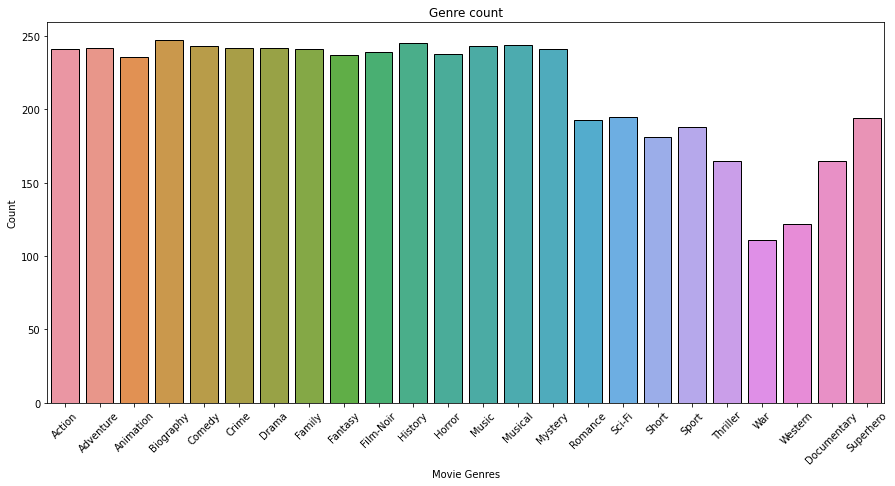

In [5]:
plt.figure(figsize=(15,7))
sns.countplot(x='genre', data=df, edgecolor=(0,0,0))
plt.xticks(rotation=45)
plt.xlabel('Movie Genres')
plt.ylabel('Count')
plt.title('Genre count')
plt.show()

In [6]:
one_hot = pd.get_dummies(df['genre'])
df = df.drop(['genre'], axis = 1)
df = df.join(one_hot)
df.head()

,title,description,img_link,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western
0,Black Panther: Wakanda Forever,The people of Wakanda fight to protect their h...,Action_01.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Andor,Prequel series to Star Wars' 'Rogue One'. In a...,Action_02.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Black Adam,"Nearly 5,000 years after he was bestowed with ...",Action_03.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,House of the Dragon,An internal succession war within House Targar...,Action_04.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Warrior Nun,"After waking up in a morgue, an orphaned teen ...",Action_05.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
'''genre_mapper = {'Action': 0, 'Adventure': 1, 'Animation': 2, 'Biography':3, 'Comedy':4, 'Crime':5, 'Documentary':6, 'Drama':7, 'Family': 8,
                'Fantasy': 9, 'Film-Noir': 10, 'History': 11, 'Horror':12, 'Music':13, 'Musical':14, 'Mystery':15, 'Romance':16, 'Sci-Fi': 17,
                'Short': 18, 'Sport': 19, 'Superhero': 20, 'Thriller':21, 'War':22, 'Western':23}
df['genre'] = df['genre'].map(genre_mapper)
df.head(10)'''

"genre_mapper = {'Action': 0, 'Adventure': 1, 'Animation': 2, 'Biography':3, 'Comedy':4, 'Crime':5, 'Documentary':6, 'Drama':7, 'Family': 8,\n                'Fantasy': 9, 'Film-Noir': 10, 'History': 11, 'Horror':12, 'Music':13, 'Musical':14, 'Mystery':15, 'Romance':16, 'Sci-Fi': 17,\n                'Short': 18, 'Sport': 19, 'Superhero': 20, 'Thriller':21, 'War':22, 'Western':23}\ndf['genre'] = df['genre'].map(genre_mapper)\ndf.head(10)"

### Text Processing

In [8]:
# Text preprocessing

def preprocess_text(text, stemm=False, lemm=True, stopwords=None):
  # Remove punctuations, lowercase, strip
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
          
  # Tokenize
  texts = text.split()    
  # Remove Stopwords
  if stopwords is not None:
      texts = [word for word in texts if word not in stopwords]
              
  # Stemming
  if stemm == True:
      ps = nltk.stem.porter.PorterStemmer()
      texts = [ps.stem(word) for word in texts]
              
  # Lemmatisation
  if lemm == True:
      lem = nltk.stem.wordnet.WordNetLemmatizer()
      texts = [lem.lemmatize(word) for word in texts]
          
  # Collect lists
  text = " ".join(texts)
  return text

In [9]:
# Loading stopwords dict
stopwords = nltk.corpus.stopwords.words("english")

In [10]:
# Doing preprocessing on texts
df['clean_title'] = df["title"].apply(lambda x: 
          preprocess_text(x, stemm=False, lemm=True, stopwords=stopwords))
df['clean_description'] = df["description"].apply(lambda x: 
          preprocess_text(x, stemm=False, lemm=True, stopwords=stopwords))
df.head()

,title,description,img_link,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western,clean_title,clean_description
0,Black Panther: Wakanda Forever,The people of Wakanda fight to protect their h...,Action_01.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,black panther wakanda forever,people wakanda fight protect home intervening ...
1,Andor,Prequel series to Star Wars' 'Rogue One'. In a...,Action_02.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,andor,prequel series star war rogue one era filled d...
2,Black Adam,"Nearly 5,000 years after he was bestowed with ...",Action_03.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,black adam,nearly 5000 year bestowed almighty power egypt...
3,House of the Dragon,An internal succession war within House Targar...,Action_04.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,house dragon,internal succession war within house targaryen...
4,Warrior Nun,"After waking up in a morgue, an orphaned teen ...",Action_05.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,warrior nun,waking morgue orphaned teen discovers posse su...


In [11]:
X = df[['clean_title', 'clean_description', 'img_link']]
y = df[one_hot.columns.tolist()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
class FilmPreditor(pl.LightningModule):
  def __init__(self, predictor: nn.Module, criterion: nn.Module, optimizer_callback: typing.Callable):
    super().__init__()
    self.predictor = predictor
    self.criterion = criterion
    self.optimizer_callback = optimizer_callback
  
  def forward(self, x):
    probs = self.predictor(x)
    return probs
  
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    preds = self.predictor(x)
    loss = self.criterion(preds, y.float())
    self.log('train_loss', loss)
    return loss
  
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    preds = self.predictor(x)
    loss = self.criterion(preds, y.float())
    self.log('val_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = self.optimizer_callback(self.predictor.parameters())
    return optimizer

In [13]:
class FilmCVDataset(Dataset):
  def __init__(self, 
               meta_df: pd.DataFrame, 
               target_df: pd.DataFrame, 
               tr: typing.Optional[typing.Callable]=None,
               is_inference: bool=False):
    self.df = meta_df
    self.y = target_df
    self.transform = tr
    self.is_inference=is_inference
  
  def __getitem__(self, idx: int):
    img_name  = self.df.iloc[idx]['img_link']
    image = torchvision.io.read_image('images/' + str(img_name), mode=torchvision.io.ImageReadMode.RGB)

    if self.transform is not None:
      image = self.transform(image)

    if self.is_inference:
      return image

    target = torch.tensor(self.y.iloc[idx].values)
    return image, target
  
  def __len__(self):
    return len(self.df)

In [14]:
preload = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [15]:
train_dl = DataLoader(FilmCVDataset(X_train, y_train, preload), batch_size=128, shuffle=True)
test_dl = DataLoader(FilmCVDataset(X_test, y_test, preload), batch_size=64, shuffle=False)
predict_dl = DataLoader(FilmCVDataset(X_test, y_test, preload, is_inference=True), batch_size=64, shuffle=False)

In [16]:
class VisualModel(nn.Module):
  def __init__(self, n_classes=24):
    super(VisualModel, self).__init__()
    self.feature_extractor = torchvision.models.resnet34()
    self.model = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.Linear(1000, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, n_classes),
        nn.Sigmoid(),
    )
    self.feature_extractor.requires_grad_(False)
  
  def forward(self, x):
    self.feature_extractor.eval()
    with torch.no_grad():
      x = self.feature_extractor(x)
    return self.model(x)

In [17]:
m = VisualModel()
visual_predictor = FilmPreditor(m, torch.nn.BCELoss(weight=torch.tensor(1.0 / y_train.mean().values)), lambda x: torch.optim.Adam(x, lr=0.0001))

In [18]:
trainer = pl.Trainer(max_epochs=10, limit_train_batches=10, limit_val_batches=1, accelerator='gpu')
trainer.fit(visual_predictor, train_dl, test_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | predictor | VisualModel | 22.1 M
1 | criterion | BCELoss     | 0     
------------------------------------------
262 K     Trainable params
21.8 M    Non-trainable params
22.1 M    Total params
88.240    Total estimated model params size (MB)


Sanity Checking:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\trainer.py:1558: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 9: 100%|██████████| 11/11 [00:06<00:00,  1.79it/s, loss=4.34, v_num=6]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 11/11 [00:06<00:00,  1.67it/s, loss=4.34, v_num=6]


In [19]:
output = trainer.predict(visual_predictor, dataloaders=predict_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 17/17 [00:04<00:00,  3.90it/s]


In [20]:
output_formated = []
y_target = []
for i, (_, y_tar) in enumerate(test_dl):
  for j in range(len(y_tar)):
    y_target.append(y_tar[j].numpy())
    output_formated.append(output[i][j].numpy())

In [21]:
output_formated = np.array(output_formated)
y_target = np.array(y_target)

y_target.shape, output_formated.shape

((1027, 24), (1027, 24))

In [22]:
def compute_metrics(y_true, y_pred):
  f1 = metrics.f1_score(y_true, y_pred, average=None)
  recall = metrics.recall_score(y_true, y_pred, average=None)
  precision = metrics.precision_score(y_true, y_pred, average=None)

  return {"f1": f1, "recall": recall, "precision": precision, "f1_macro": f1.mean(), "recall_macro": recall.mean(), "precision_macro": precision.mean()}


In [23]:
y_pred = output_formated.copy()
t = 0.05
y_pred[y_pred > t] = 1
y_pred[y_pred <= t] = 0
metrics_dict = compute_metrics(y_target, y_pred)
metrics_dict

{'f1': array([0.07853403, 0.11091854, 0.08997429, 0.08      , 0.084     ,
        0.08203125, 0.03508772, 0.0950495 , 0.07771429, 0.11074919,
        0.03125   , 0.11311054, 0.1043956 , 0.09182209, 0.09107468,
        0.08571429, 0.05434783, 0.09556314, 0.02586207, 0.06451613,
        0.07281553, 0.08333333, 0.02222222, 0.07361963]),
 'recall': array([0.34883721, 0.54237288, 0.71428571, 0.40909091, 0.42      ,
        0.41176471, 0.05882353, 0.53333333, 0.80952381, 0.38636364,
        0.14893617, 0.44897959, 0.38      , 0.61538462, 0.43859649,
        0.17307692, 0.25641026, 0.29166667, 0.08333333, 0.3030303 ,
        0.42857143, 0.26666667, 0.07142857, 0.25      ]),
 'precision': array([0.04424779, 0.06177606, 0.04801097, 0.04433498, 0.04666667,
        0.04555315, 0.025     , 0.05217391, 0.04081633, 0.06463878,
        0.01745636, 0.06470588, 0.06050955, 0.0496124 , 0.05081301,
        0.05696203, 0.03039514, 0.05714286, 0.01530612, 0.03610108,
        0.0397878 , 0.04938272, 0.01315

In [29]:
class FilmTextDataset(Dataset):
  def __init__(self, 
               meta_df: pd.DataFrame, 
               target_df: pd.DataFrame,
               is_inference:bool=False):
    self.df = meta_df
    self.y = target_df
    self.tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
    self.max_seq_len = 120
    self.is_inference=is_inference
  
  def __getitem__(self, idx: int):
    text  = str(self.df.iloc[idx]['clean_title']) + ' # ' + str(self.df.iloc[idx]['clean_description'])
    tokenized = self.tokenizer(text, max_length=self.max_seq_len, padding='max_length')
    target = torch.tensor(self.y.iloc[idx].values)
    if self.is_inference:
      return {k: torch.tensor(v) for k, v in tokenized.items()}

    return {k: torch.tensor(v) for k, v in tokenized.items()}, target
  
  def __len__(self):
    return len(self.df)

In [30]:
class TextModel(nn.Module):
  def __init__(self, n_classes=24):
    super(TextModel, self).__init__()
    self.bert = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity", 
                                                              num_labels=n_classes,
                                                              ignore_mismatched_sizes=True)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    return self.sigmoid(self.bert(**x).logits)

In [31]:
train_dl = DataLoader(FilmTextDataset(X_train, y_train), batch_size=8, shuffle=True)
test_dl = DataLoader(FilmTextDataset(X_test, y_test), batch_size=8, shuffle=False)
predict_dl = DataLoader(FilmTextDataset(X_test, y_test, is_inference=True), batch_size=16, shuffle=False)

In [32]:
m = TextModel()
text_predictor = FilmPreditor(m, torch.nn.BCELoss(), lambda x: torch.optim.Adam(x, lr=5e-5))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at textattack/bert-base-uncased-yelp-polarity and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([24, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([24]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
trainer = pl.Trainer(max_epochs=2, val_check_interval=0.5, accelerator='gpu')
trainer.fit(text_predictor, train_dl, test_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | predictor | TextModel | 109 M 
1 | criterion | BCELoss   | 0     
----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.003   Total estimated model params size (MB)


c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: 100%|██████████| 772/772 [02:31<00:00,  5.11it/s, loss=0.172, v_num=7]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 772/772 [02:31<00:00,  5.11it/s, loss=0.172, v_num=7]


In [34]:
output = trainer.predict(text_predictor, dataloaders=predict_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 65/65 [00:14<00:00,  4.49it/s]


In [35]:
output_formated = []
y_target = []
for i, (_, y_tar) in enumerate(test_dl):
  for j in range(len(y_tar)):
    y_target.append(y_tar[j].numpy())
    output_formated.append(output[i][j].numpy())

IndexError: index 3 is out of bounds for dimension 0 with size 3